In [169]:
import os
import random
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import yaml
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
import pdb
import sys
sys.path.append('..')
from template import utils

In [170]:
utils.set_random_seeds()

In [171]:
# setting config
config = yaml.safe_load(open("config.yaml"))
batch_size = int(config["BATCH_SIZE"])

print(f"Our config: {config}")

Our config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [172]:
LFWPeople_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2),
    ])

In [173]:
train_dataset = datasets.LFWPeople(root='./data', transform=LFWPeople_tf, split="train",download=True)
test_dataset = datasets.LFWPeople(root='./data', transform=LFWPeople_tf, split="test",download=True)
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [0.5, 0.5])

Files already downloaded and verified
Files already downloaded and verified


In [174]:
print(f"train set size: {len(train_dataset)}")
print(f"validation set size: {len(val_dataset)}")
print(f"test set size: {len(test_dataset)}")

train set size: 9525
validation set size: 1854
test set size: 1854


In [191]:
class TripletDataset:
    """
    Dataset class from which we sample random triplets
    """
    def __init__(self, dataset):
        """ Dataset initializer"""
        self.dataset = dataset
        self.arange = np.arange(len(dataset))
        self.labels = torch.Tensor([l for _,l in dataset])
        self._clean_singular_anchors()
        return
    
    def __len__(self):
        """ Returning number of anchors """
        return len(self.dataset)
    
    def _clean_singular_anchors(self):
        """ This method cleans the dataset. It deletes the samples, in which there was only one face (cannot create positive and anchor faces).
        """
        singular_anchors = []
        for i in range(len(self.dataset)):
            _ , anchor_lbl = self.dataset[i]
            pos_ids = self.arange[torch.where(self.labels == anchor_lbl)]
            if isinstance(pos_ids, np.int64):
                singular_anchors.append(i)

        self.dataset = [self.dataset[i] for i in range(len(self.dataset)) if i not in singular_anchors]
        self.labels = torch.Tensor([l for _,l in self.dataset])
        self.arange = np.arange(len(self.dataset))

    def __getitem__(self, i):
        """ 
        Sampling a triplet for the dataset. Index i corresponds to anchor 
        """
        # sampling anchor
        anchor_img, anchor_lbl = self.dataset[i]
        
        
        # lists for positives and negatives
        pos_ids = self.arange[torch.where(self.labels == anchor_lbl)]
        neg_id = self.arange[torch.where(self.labels != anchor_lbl)]
        
        pos_ids = np.delete(pos_ids, 0) # Deleting anchor face from the positive faces. Anchor id is always at the beggining of an array.
        
        pos_id, neg_id = random.choice(pos_ids).item(), random.choice(neg_id).item()
        pos_img, pos_lbl = self.dataset[pos_id] 
        neg_img, neg_lbl = self.dataset[neg_id]
              
        return (anchor_img, pos_img, neg_img), (anchor_lbl, pos_lbl, neg_lbl)

In [192]:
tri_train_dataset = TripletDataset(train_dataset)
tri_val_dataset = TripletDataset(val_dataset)
tri_test_dataset = TripletDataset(test_dataset)

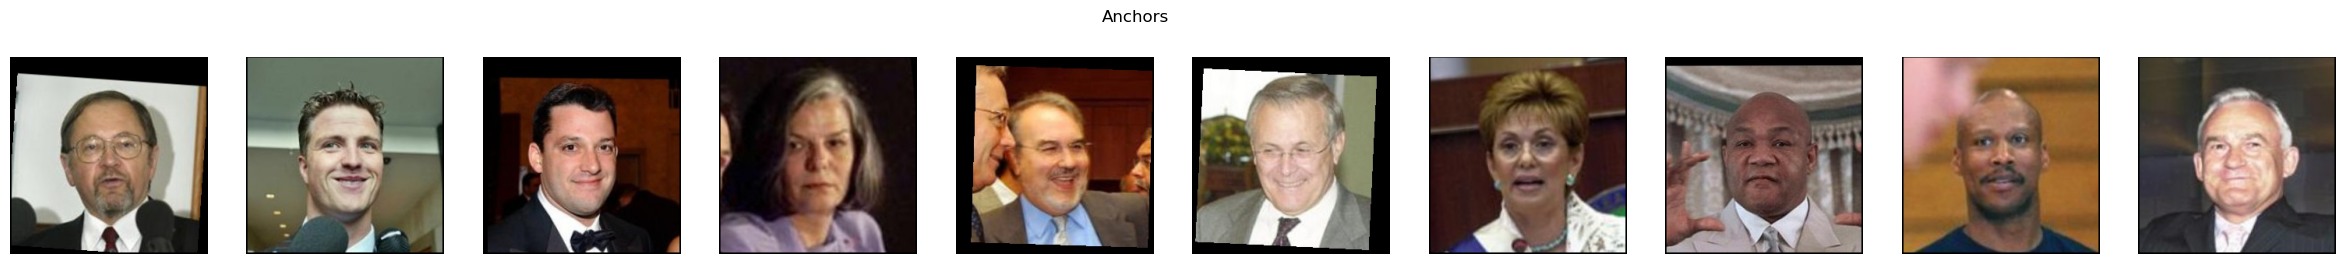

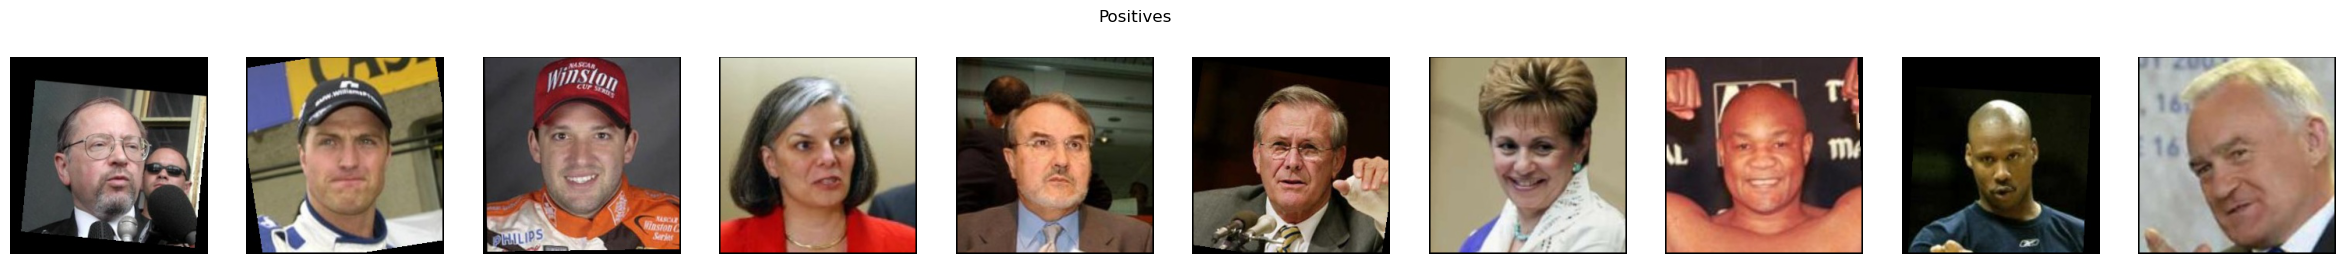

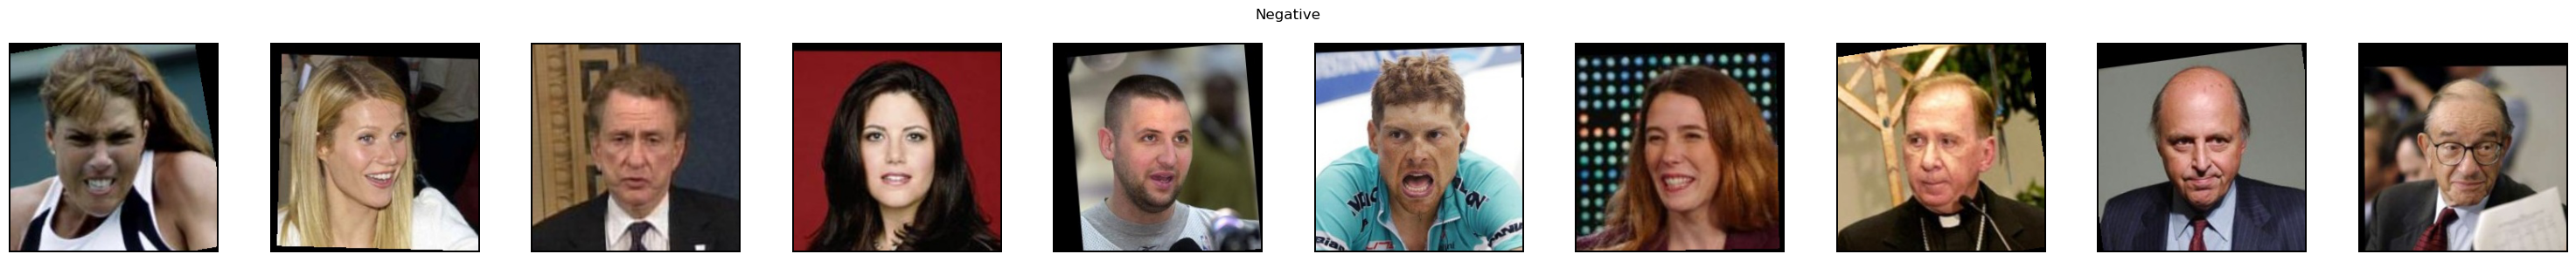

In [193]:
fig_anchors, anchors = plt.subplots(1, 10, figsize=(30,3))
fig_pos, positives = plt.subplots(1, 10, figsize=(30,3))
fig_neg, negatives = plt.subplots(1, 10, figsize=(30,3))
for i in range(10):
    try:
        (anchor, positive, negative), _ = tri_val_dataset[i]
        anchor = anchor.numpy().reshape(3,254,254).transpose(1, 2, 0)
        positive = positive.numpy().reshape(3,254,254).transpose(1, 2, 0)
        negative = negative.numpy().reshape(3,254,254).transpose(1, 2, 0)
        anchors[i].imshow(anchor)
        anchors[i].axis("off")
        positives[i].imshow(positive)
        positives[i].axis("off")
        negatives[i].imshow(negative)
        negatives[i].axis("off")
    except ValueError:
        continue
fig_anchors.suptitle("Anchors")
fig_pos.suptitle("Positives")
fig_neg.suptitle("Negative")
plt.tight_layout()